In [53]:
import ROOT as root
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [54]:
thisParticle = 2212
thisMass = 938.28
Analyse_Secondaries = 1
Theta_min_cut = 0.0 

MaxHits = 50000
MaxPMTNo = 20
MaxPMTHits = 5000
Finger_Edep_Max = 10.0
AnaBar_Edep_Max = 10.0
pedastel_sigma = 2.9
Detector_Offset = 0

Finger_NPhotons_Max = 250
AnaBar_NPhotons_Max = 200

NUMPADDLE = 14

NMaxPMT = 14

Detector_pdg = np.array([0 for i in range(MaxHits)],dtype=int)
Detector_id = np.array([0 for i in range(MaxHits)],dtype=int)

Detector_x = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_y = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_z = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_t = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_Ed = np.array([0 for i in range(MaxHits)],dtype=float)

PMT_Nphotons = np.array([0 for i in range(MaxPMTNo)],dtype=int)
PMT_Nphotons_Noise = np.array([0 for i in range(MaxPMTNo)],dtype=int)

PMT_KineticEnergy = np.array([[0 for i in range(MaxPMTNo)] for j in range(MaxPMTHits)],dtype=float)

In [55]:
"""
def langaufun(x, par):
    invsq2pi = 0.3989422804014
    mpshift  = -0.22278298
    
    np = 100.0
    sc =   5.0
    
    sum = 0.0
    
    mpc = par[1] - mpshift * par[0]
    xlow = x[0] - sc * par[3]
    xupp = x[0] + sc * par[3]
    
    step = (xupp-xlow) / np
    
    for i in range(np//2):
        xx = xlow + (i-.5) * step
        
        fland = TMath::Landau(xx,mpc,par[0]) / par[0]
        sum += fland * TMath::Gaus(x[0],xx,par[3])
        xx = xupp - (i-.5) * step
        
        fland = TMath::Landau(xx,mpc,par[0]) / par[0]
        sum += fland * TMath::Gaus(x[0],xx,par[3])
    return (par[2] * step * sum * invsq2pi / par[3])



def langaufit(his, fitrange, startvalues, parlimitslo, parlimitshi, fitparams, fiterrors, ChiSqr, NDF):
    funname = np.array('' for i in range(100),dtype=str)
    
    sprintf(FunName,"Fitfcn_%s",his.GetName())
    
    ffitold = (TF1)gROOT.GetListOfFunctions().FindObject(FunName)
    if (ffitold):
        delete ffitold
    
    ffit = root.TF1(FunName,langaufun,fitrange[0],fitrange[1],4)
    ffit.SetParameters(startvalues)
    ffit.SetParNames("Width","MP","Area","GSigma")
    
    for i in range(4):
        ffit.SetParLimits(i, parlimitslo[i], parlimitshi[i])
        
    his.Fit(FunName,"RB0")
    
    ffit.GetParameters(fitparams)
    
    for i in range(4):
        fiterrors[i] = ffit.GetParError(i)
        
    ChiSqr[0] = ffit.GetChisquare()
    NDF[0] = ffit.GetNDF()
    
    return ffit
"""

'\ndef langaufun(x, par):\n    invsq2pi = 0.3989422804014\n    mpshift  = -0.22278298\n    \n    np = 100.0\n    sc =   5.0\n    \n    sum = 0.0\n    \n    mpc = par[1] - mpshift * par[0]\n    xlow = x[0] - sc * par[3]\n    xupp = x[0] + sc * par[3]\n    \n    step = (xupp-xlow) / np\n    \n    for i in range(np//2):\n        xx = xlow + (i-.5) * step\n        \n        fland = TMath::Landau(xx,mpc,par[0]) / par[0]\n        sum += fland * TMath::Gaus(x[0],xx,par[3])\n        xx = xupp - (i-.5) * step\n        \n        fland = TMath::Landau(xx,mpc,par[0]) / par[0]\n        sum += fland * TMath::Gaus(x[0],xx,par[3])\n    return (par[2] * step * sum * invsq2pi / par[3])\n\n\n\ndef langaufit(his, fitrange, startvalues, parlimitslo, parlimitshi, fitparams, fiterrors, ChiSqr, NDF):\n    funname = np.array(\'\' for i in range(100),dtype=str)\n    \n    sprintf(FunName,"Fitfcn_%s",his.GetName())\n    \n    ffitold = (TF1)gROOT.GetListOfFunctions().FindObject(FunName)\n    if (ffitold):\n     

In [56]:
f = root.TFile("data/AnaBarMC_99999.root")
f.ls()

myTree = f.Get("T")

entries = myTree.GetEntriesFast()

hFingerX = root.TH1F("FingerX","Finger X Position",100,-120,120)
hFingerY = root.TH1F("FingerY","Finger Y Position",100,30,80)
hFingerZ = root.TH1F("FingerZ","Finger Z Position",100,-140,60)
hFingerT = root.TH1F("FingerT","Finger Time",100,0.0,0.4)

hPrimE = root.TH1F("PrimE","Primary Energy", 100, 0, 25000)
hPrimTh = root.TH1F("PrimTh","Primary Theta", 100, 0, np.pi)
hPrimPh = root.TH1F("PrimPh","Primary Phi", 100, 0, 2.0*np.pi)
hPrimPdg = root.TH1F("PrimPdg","Primary PDG ID", 30, 0, 30)

hDetectorNhits = root.TH1F("DetectorNhits","Detector Number of Hits", 100, 0, 400)
hDetectorPdg = root.TH1F("DetectorPdg","Detector PDG ID", 50, -20, 30)
hDetectorID = root.TH1F("DetectorID","Detector ID Number", 30, 0, 30)
hPMTID = root.TH1F("PMTID","PMT ID Number", 15, 0, 15)

hFingerPMTNphot = root.TH1F("FingerPMTNphot","Finger PMT Number of Photons", Finger_NPhotons_Max+10, -10, Finger_NPhotons_Max)
hFingerEd = root.TH1F("FingerEd","Finger Energy Deposited", 100, 0.01, Finger_Edep_Max)

hAnaBarPMTNphot = []

for i in range(NUMPADDLE):  
    name = ("AnaBarPMTNphotA%d" % i)
    title = ("AnaBar_PMT_Number_of_Photons_A%d" % i)
    print (name,title)
    hAnaBarPMTNphot.append(root.TH1F(name, title, int(AnaBar_NPhotons_Max*0.9+20), -20, int(AnaBar_NPhotons_Max*0.9)))

hAnaBarEd = root.TH1F("AnaBarEd","AnaBar Energy Deposited", 100, 0.01, AnaBar_Edep_Max)

hAnaBarX = root.TH1F("AnaBarX","AnaBar X Position", 100, -120, 120)
hAnaBarY = root.TH1F("AnaBarY","AnaBar Y Position", 100, -30, 30)
hAnaBarZ = root.TH1F("AnaBarZ","AnaBar Z Position", 100, -30, 30)
hAnaBarT = root.TH1F("AnaBarT","AnaBar Time", 100, 0, .4)

hE1vsE2 = root.TH2F("E1vsE2", "AnaBar Edep vs. Finger Edep", 100, 0.01, Finger_Edep_Max, 100, 0.01, AnaBar_Edep_Max)

hFinger_Edep_vs_Nphot = root.TH2F("FingerEdepVsNphot", "Finger Edep vs. Number of Photons", Finger_NPhotons_Max, 0, Finger_NPhotons_Max, 100, 0.01, Finger_Edep_Max)
hNphot0_vs_Nphot1 = root.TH2F("AnaBarVsFingerNphot", "AnaBar vs. Finger Number of Photons", AnaBar_NPhotons_Max, 0, AnaBar_NPhotons_Max, Finger_NPhotons_Max, 0, Finger_NPhotons_Max)
hAnaBar_Edep_vs_Nphot = root.TH2F("AnaBarEdepVsNphot", "AnaBar Edep vs. Number of Photons", AnaBar_NPhotons_Max, 0, AnaBar_NPhotons_Max, 100, 0.01, AnaBar_Edep_Max)

PMT_Nphotons_Total = 0

hAnaBarEdAll = []

for i in range(NUMPADDLE):
    name = ("AnaBarEd%d" % i)
    title = ("AnaBar Energy Deposited A%d" % i)
    hAnaBarEdAll.append(root.TH1F(name, title, 100, 0.01, AnaBar_Edep_Max))

hAnaBarPMTNoiseCutNphot = []

for i in range(NUMPADDLE):
    name = ("AnaBarPMTNoiseCutNphotA%d" % i)
    title = ("AnaBar PMT Number of Photons A%d" % i)
    hAnaBarPMTNoiseCutNphot.append(root.TH1F(name, title, AnaBar_NPhotons_Max+20, -20, AnaBar_NPhotons_Max))
   # hAnaBarPMTNoiseCutNphot[i].SetLineColor("red")

hFingerPMTKE = root.TH1F("FingerPMTKE","Photon Wavelength Production Spectrum", 400, 300.0, 700.0)
hAnaBarPMTKEA1 = root.TH1F("AnaBarPMTKEA1","Photon Wavelength in WLS at PMT", 400, 300.0, 700.0)

hAnaBarMult = root.TH1F("AnaBarMult","Anabar PMT Multiplicity",12,0,12)

hPrimPx = root.TH1F("PrimPx","Primary Px", 100, -2000, 2000)
hPrimPz = root.TH1F("PrimPz","Primary Pz", 100, -2000, 2000)
hPrimPy = root.TH1F("PrimPy","Primary Py", 100, -25000, 0)


for i in range(entries):
    
    if (i%100 == 0):
        print("Event Number: %d" % i)
    
    anabar_hit_paddle = np.array([False for i in range(NMaxPMT)],dtype=bool)
    edeptot = np.array([0.0 for i in range(NMaxPMT)],dtype=float)
    edep0tot = 0.0
    
    myTree.GetEntry(i)
    
    trigger = False
    finger_hit = False
    anabar_hit = False
    anabar_top_hit = False
    anabar_bottom_hit = False
    j_finger = 0
    j_anabar = 0
    
    trigger2 = False
    
    fMass = thisMass
    fMomentum = np.sqrt(myTree.Prim_E**2 - fMass**2)
    fPx = fMomentum*np.sin(myTree.Prim_Th)*np.cos(myTree.Prim_Ph)
    fPy = fMomentum*np.sin(myTree.Prim_Th)*np.sin(myTree.Prim_Ph)
    fPz = fMomentum*np.cos(myTree.Prim_Th)
    fNewTheta = np.arccos(fPy/fMomentum)
    if (fPx>0 and fPz<0):
        fNewPhi = np.arctan(fPz/fPx)+np.pi
    else:
        if (fPx>0 and fPz<0):
            fNewPhi = np.arctan(fPz/fPx)+2.0*np.pi
        else:
            fNewPhi=np.arctan(fPz/fPx)
    
    for j in range(myTree.Detector_Nhits):
        if(myTree.Detector_id[j] == Detector_Offset and not finger_hit):
            finger_hit = True
            j_finger = j
            
        for ibar in range(15):
            if(myTree.Detector_id[j+Detector_Offset] == ibar+Detector_Offset):
                anabar_hit = True
                anabar_hit_paddle[ibar-1]=True
                j_anabar = j
            
    if (finger_hit and anabar_hit):
        trigger = True
        
    if (finger_hit and anabar_hit and fNewTheta > 2.524):
        trigger2 = True
        
    for j in range(myTree.Detector_Nhits):
        if trigger:
            if (myTree.Detector_id[j] == Detector_Offset and myTree.Detector_pdg[j] == thisParticle):
                hFingerX.Fill(myTree.Detector_x[j])
                hFingerY.Fill(myTree.Detector_y[j])
                hFingerZ.Fill(myTree.Detector_z[j])
                hFingerT.Fill(myTree.Detector_t[j])
                
            if (myTree.Detector_id[j] == Detector_Offset):
                hDetectorPdg.Fill(myTree.Detector_pdg[j])
                hDetectorID.Fill(myTree.Detector_id[j])
                
            if (myTree.Detector_id[j] == (1 + Detector_Offset)):
                hDetectorPdg.Fill(myTree.Detector_pdg[j])
                hDetectorID.Fill(myTree.Detector_id[j])
                
            for icount in range(15):
                PMT_Nphotons_Noise[icount]=myTree.PMT_Nphotons[icount]+np.random.normal(loc=0.0,scale=pedastel_sigma)
                
            for i in range(NUMPADDLE):
                hAnaBarPMTNphot[i].Fill(PMT_Nphotons_Noise[i])
                
            hFingerPMTNphot.Fill(PMT_Nphotons_Noise[14])
            
            if (myTree.Detector_id[j] == (1 + Detector_Offset) and myTree.Detector_pdg[j] == thisParticle):
                hAnaBarX.Fill(myTree.Detector_x[j])
                hAnaBarY.Fill(myTree.Detector_y[j])
                hAnaBarZ.Fill(myTree.Detector_z[j])
                hAnaBarT.Fill(myTree.Detector_t[j])

            
    for j in range(myTree.Detector_Nhits):

        if (trigger):
            if (myTree.Detector_id[j] == Detector_Offset ):
                if (Analyse_Secondaries == 1 and fNewTheta > Theta_min_cut):
                    edep0tot += myTree.Detector_Ed[j];
                else:
                    if (myTree.Detector_pdg[j] == thisParticle and fNewTheta > Theta_min_cut):
                        edep0tot += myTree.Detector_Ed[j];
                        
            if (myTree.Detector_id[j] > Detector_Offset and myTree.Detector_id[j] <= NMaxPMT+Detector_Offset):
                if (Analyse_Secondaries == 1 and fNewTheta > Theta_min_cut):
                    edeptot[myTree.Detector_id[j]-1-Detector_Offset] += myTree.Detector_Ed[j]
                else:
                    if (myTree.Detector_pdg[j] == thisParticle and fNewTheta > Theta_min_cut):
                        edeptot[myTree.Detector_id[j]-1-Detector_Offset] += myTree.Detector_Ed[j]
                        
    
                        
            
    if trigger:
        hFingerEd.Fill(edep0tot)
        hAnaBarEd.Fill(edeptot[6])
        
        hE1vsE2.Fill(edep0tot, edeptot[6])
        
        #for jq in range(myTree.PMT_Nphotons[14]):
         #   hFingerPMTKE.Fill(1240.0/myTree.PMT_KineticEnergy[14][jq])
            
        #for iq in range(NUMPADDLE):
         #   for jq in range(myTree.PMT_Nphotons[14]):
          #      hAnaBarPMTKEA1.Fill(1240.0/myTree.PMT_KineticEnergy[iq][jq])
        
        imult = 0
        for icount in range(NUMPADDLE):
            if(PMT_Nphotons_Noise[icount]>=8):
                imult += 1
        
        hAnaBarMult.Fill(imult)
        
    if trigger2:    
        for icount in range(14):
            PMT_Nphotons_Total += myTree.PMT_Nphotons[icount]
        
        hFinger_Edep_vs_Nphot.Fill(myTree.PMT_Nphotons[14],edep0tot)
        hAnaBar_Edep_vs_Nphot.Fill(myTree.PMT_Nphotons[6],edeptot[6])
        hNphot0_vs_Nphot1.Fill(PMT_Nphotons_Total,myTree.PMT_Nphotons[14])
        
        for i in range(NUMPADDLE):
            hAnaBarEdAll[i].Fill(edeptot[i])
            
            if(anabar_hit_paddle[i] and edeptot[i]>=0.0):
                hAnaBarPMTNoiseCutNphot[i].Fill(PMT_Nphotons_Noise[i])
            
        
        
    
        
    hPrimE.Fill(myTree.Prim_E)
    hPrimTh.Fill(fNewTheta)
    hPrimPh.Fill(fNewPhi)
    hPrimPdg.Fill(myTree.Prim_pdg)
    
    hPMTID.Fill(myTree.PMT_id)
    hDetectorNhits.Fill(myTree.Detector_Nhits)
    
    hPrimPx.Fill(fPx)
    hPrimPy.Fill(fPy)
    hPrimPz.Fill(fPz)
    
    

c1 = root.TCanvas("c1","c1",800,800)
c1.Divide(2,2,0.01,0.01,0)

c1.cd(1)
hFingerX.Draw()
c1.cd(2)
hFingerY.Draw()
c1.cd(3)
hFingerZ.Draw()
c1.cd(4)
hFingerT.Draw()

AnaBarPMTNphotA0 AnaBar_PMT_Number_of_Photons_A0
AnaBarPMTNphotA1 AnaBar_PMT_Number_of_Photons_A1
AnaBarPMTNphotA2 AnaBar_PMT_Number_of_Photons_A2
AnaBarPMTNphotA3 AnaBar_PMT_Number_of_Photons_A3
AnaBarPMTNphotA4 AnaBar_PMT_Number_of_Photons_A4
AnaBarPMTNphotA5 AnaBar_PMT_Number_of_Photons_A5
AnaBarPMTNphotA6 AnaBar_PMT_Number_of_Photons_A6
AnaBarPMTNphotA7 AnaBar_PMT_Number_of_Photons_A7
AnaBarPMTNphotA8 AnaBar_PMT_Number_of_Photons_A8
AnaBarPMTNphotA9 AnaBar_PMT_Number_of_Photons_A9
AnaBarPMTNphotA10 AnaBar_PMT_Number_of_Photons_A10
AnaBarPMTNphotA11 AnaBar_PMT_Number_of_Photons_A11
AnaBarPMTNphotA12 AnaBar_PMT_Number_of_Photons_A12
AnaBarPMTNphotA13 AnaBar_PMT_Number_of_Photons_A13
Event Number: 0
Event Number: 100
Event Number: 200
Event Number: 300
Event Number: 400
Event Number: 500
Event Number: 600
Event Number: 700
Event Number: 800
Event Number: 900
Event Number: 1000
Event Number: 1100
Event Number: 1200
Event Number: 1300
Event Number: 1400
Event Number: 1500
Event Number: 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


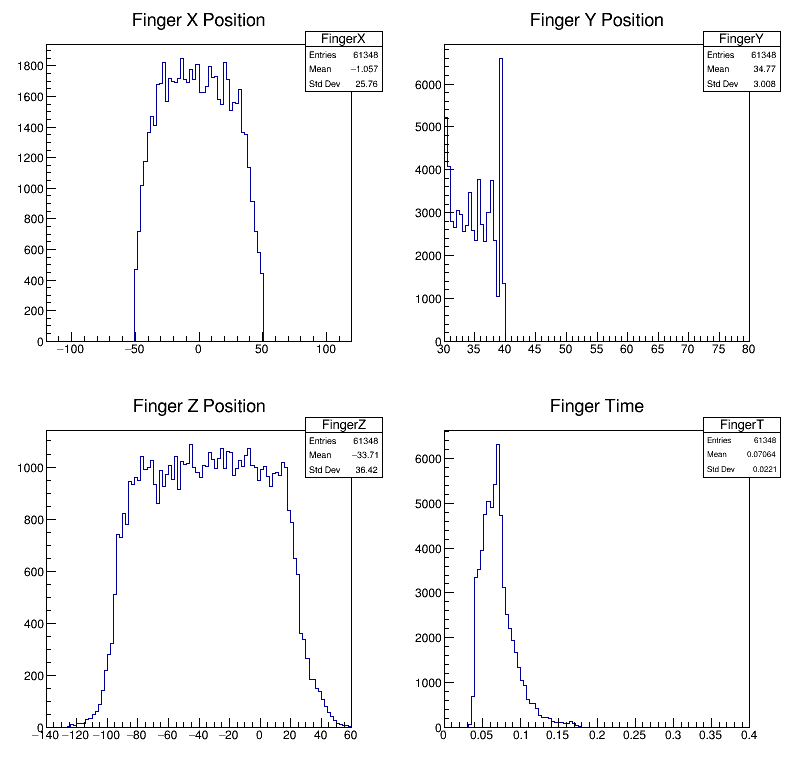

In [57]:
c1.Draw()

In [58]:
c2 = root.TCanvas("c2","c2",800,800)
c2.Divide(2,2,0.01,0.01,0)

c2.cd(1)
hPrimE.Draw()
c2.cd(2)
hPrimTh.Draw()
c2.cd(3)
hPrimPh.Draw()
c2.cd(4)
hPrimPdg.Draw()

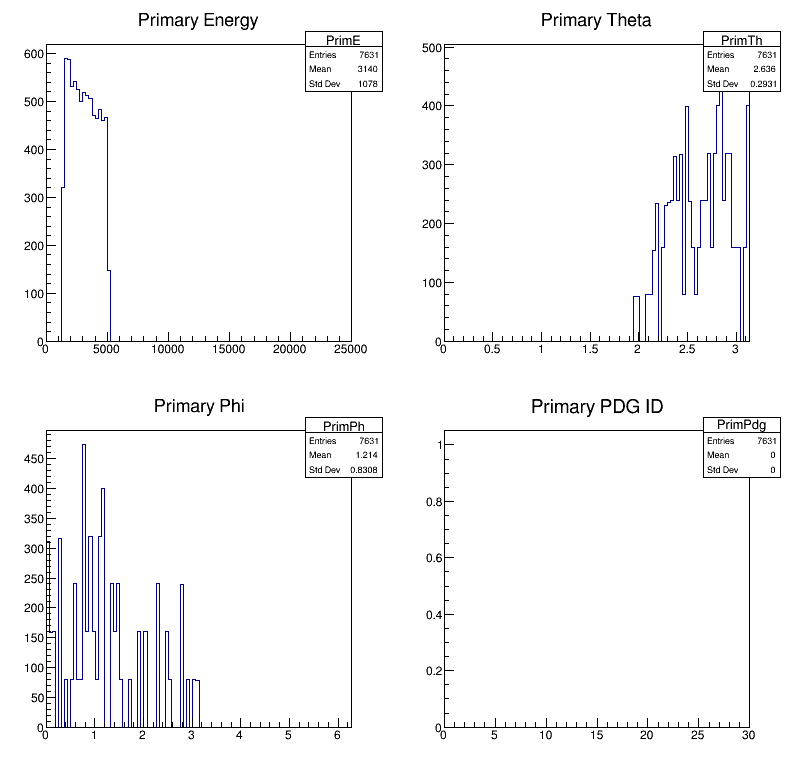

In [59]:
c2.Draw()

In [60]:
c3 = root.TCanvas("c3","c3",800,800)
c3.Divide(2,2,0.01,0.01,0)

c3.cd(1)
hDetectorNhits.Draw()
c3.cd(2)
hDetectorPdg.Draw()
c3.cd(3)
hDetectorID.Draw()
c3.cd(4)
hPMTID.Draw()

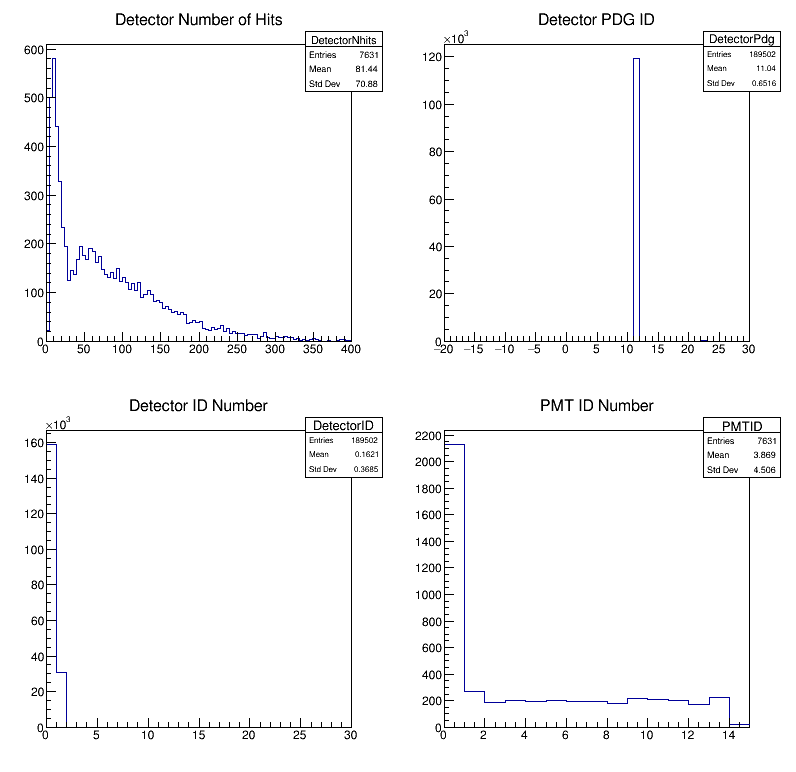

In [61]:
c3.Draw()

In [62]:
c4 = root.TCanvas("c4", "c4", 800,800)
c4.Divide(2,2, 0.01, 0.01, 0)
  
c4.cd(1)
hFingerEd.Draw()
c4.cd(2);
hFingerPMTNphot.Draw()
c4.cd(3)
hAnaBarEd.Draw()
c4.cd(4)
hAnaBarPMTNphot[0].Draw()

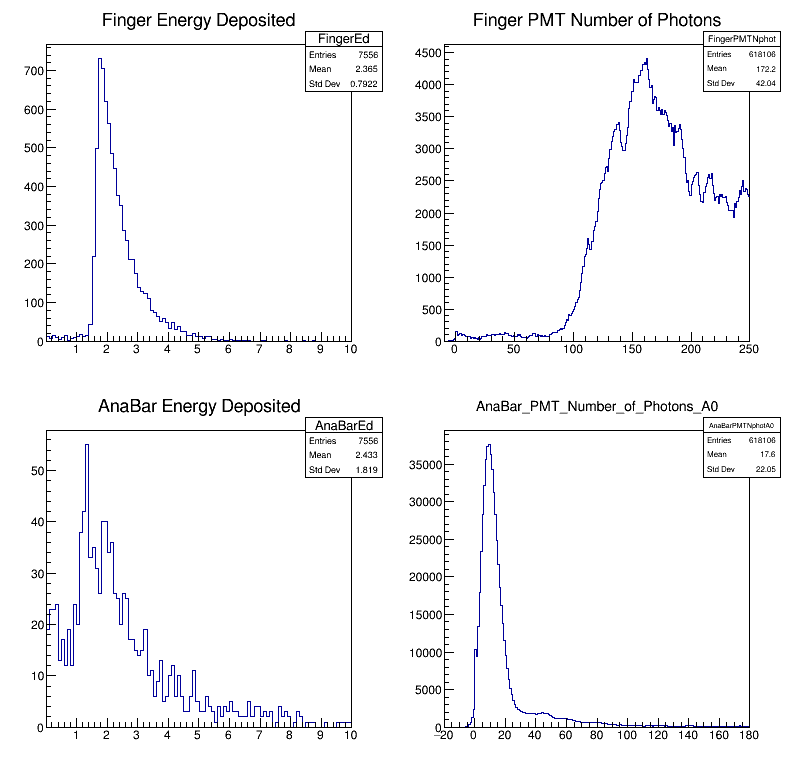

In [63]:
c4.Draw()

In [64]:
c5 = root.TCanvas("c5", "c5", 800,800)
c5.Divide(2,2, 0.01, 0.01, 0)

c5.cd(1)
hAnaBarX.Draw()
c5.cd(2)
hAnaBarY.Draw()
c5.cd(3)
hAnaBarZ.Draw()
c5.cd(4)
hAnaBarT.Draw()

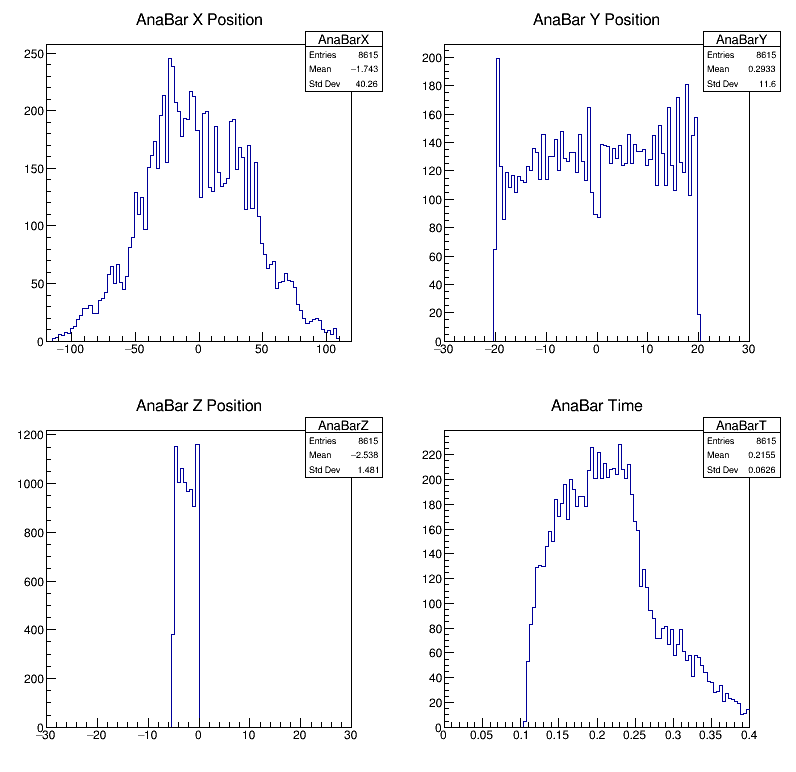

In [65]:
c5.Draw()

In [66]:
c6 = root.TCanvas("c6", "c6", 800, 800)
c6.Divide(1,1, 0.01, 0.01, 0)

c6.cd(1)
hE1vsE2.Draw("COLZ")

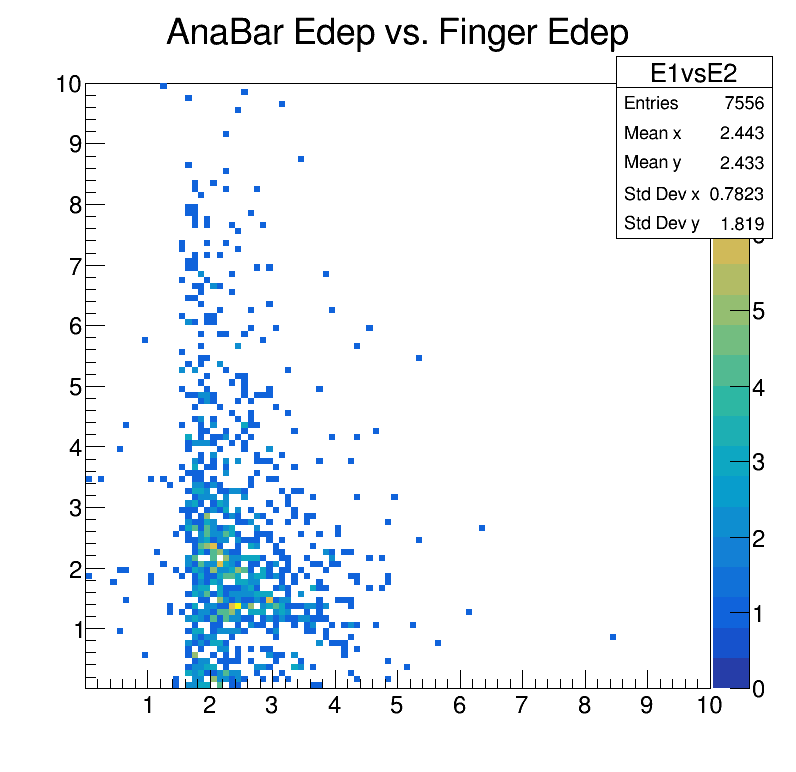

In [67]:
c6.Draw()

In [68]:
c7 = root.TCanvas("c7", "c7", 800, 800)
c7.Divide(2,2, 0.01, 0.01, 0)

c7PE_MeV = root.TCanvas("c7PE_MeV", "c7PE_MeV", 800,800)
c7Profile = root.TCanvas("c7Profile", "c7Profile", 800,800)

c7.cd(1)
hFinger_Edep_vs_Nphot.Draw("COLZ")
c7.cd(2)
hAnaBar_Edep_vs_Nphot.Draw("COLZ")
c7.cd(3)
hNphot0_vs_Nphot1.Draw("COLZ")

c7Profile.cd()
prof = hAnaBar_Edep_vs_Nphot.ProfileX()

prof.Fit("pol1")

c7PE_MeV.cd()
hAnaBar_Edep_vs_Nphot.Draw("COLZ")


****************************************
Minimizer is Linear / Migrad
Chi2                      =      412.727
NDf                       =          102
p0                        =   -0.0472278   +/-   0.0138565   
p1                        =    0.0542242   +/-   0.000228938 


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c7
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c7PE_MeV
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c7Profile


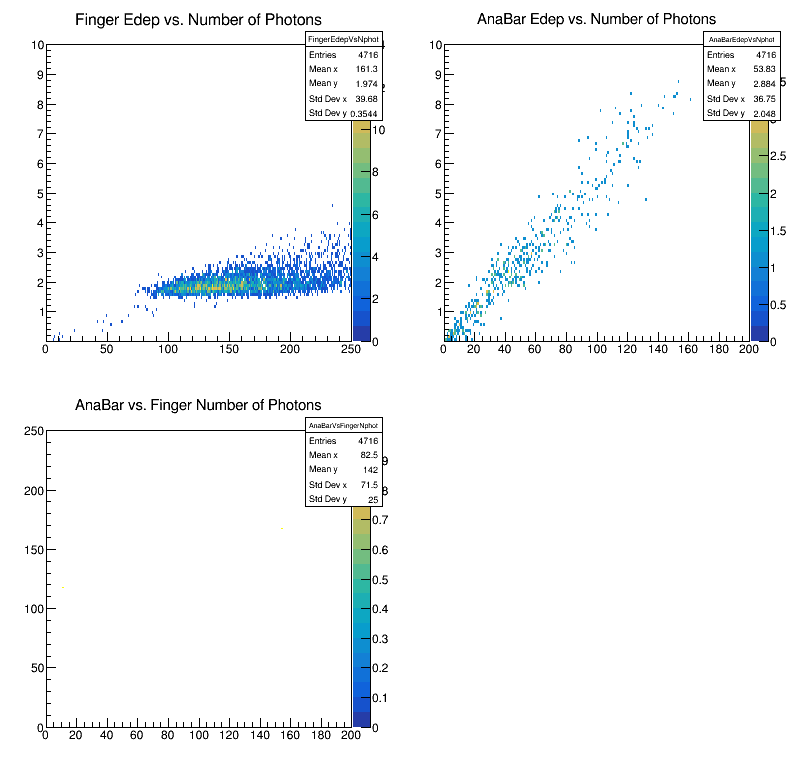

In [69]:
c7.Draw()

In [70]:
c8 = root.TCanvas("c8", "c8", 800,800)
c8.Divide(2,2, 0.01, 0.01, 0)

cEd = root.TCanvas("cEd", "cEd", 800,800)
cEd.Divide(4,4)

cEdOne = root.TCanvas("cEdOne", "cEdOne", 800, 800)

c8.cd(1)
hAnaBarEd.Draw()
c8.cd(2)
hAnaBarPMTNphot[6].Draw()
c8.cd(3)
hAnaBar_Edep_vs_Nphot.Draw("COLZ")

means = []
meanErr = []

function = root.TF1()

for i in range(NUMPADDLE):
    if (i+1 == 3):
        cEdOne.cd()
    else:
        cEd.cd(i+1)
        
    hAnaBarEdAll[i].Draw()
    start = 4.0
    
    gf = root.TF1("gf", "gaus", start, AnaBar_Edep_Max)
    hAnaBarEdAll[i].Fit(gf, "R")
    function = hAnaBarEdAll[i].GetFunction("gf")
    function.SetLineColor(1)
    
    means.append(function.GetParameter(1))
    meanErr.append(function.GetParError(1))

for i in range(NUMPADDLE):
    print("Paddle " + str(i+1) + ": Mean peak Edep = " + str(means[i]) + " MeV")
    print("    \t Mean Edep error = " +str(meanErr[i]) + " MeV")
    
sumMeans = 0.0
sumMeanErrSqrs = 0.0

for i in range(NUMPADDLE):
    sumMeans += means[i]
    sumMeanErrSqrs += meanErr[i]*meanErr[i]

print("Sum of mean error squares = " + str(sumMeanErrSqrs))

meanMean = sumMeans/NUMPADDLE

sumErr = np.sqrt(sumMeanErrSqrs)
print("Error in sum of means = " + str(sumErr))
meanMeanErr = sumErr/NUMPADDLE

print("Mean peak Edep across all paddles: " + str(meanMean) + " MeV" )
print("Mean peak Edep uncertainty: " + str(meanMeanErr) + " Mev")

Paddle 1: Mean peak Edep = -35.79847667137926 MeV
    	 Mean Edep error = 27.375602495142555 MeV
Paddle 2: Mean peak Edep = -23.886605677922265 MeV
    	 Mean Edep error = 1.4142135623730951 MeV
Paddle 3: Mean peak Edep = -23.564547945826973 MeV
    	 Mean Edep error = 14.047952936180318 MeV
Paddle 4: Mean peak Edep = -51.7487544022938 MeV
    	 Mean Edep error = 50.28651114485485 MeV
Paddle 5: Mean peak Edep = 5.096271168499438 MeV
    	 Mean Edep error = 1.251580764984884 MeV
Paddle 6: Mean peak Edep = -28.00539565613871 MeV
    	 Mean Edep error = 14.686291624460516 MeV
Paddle 7: Mean peak Edep = -46.66330875631037 MeV
    	 Mean Edep error = 39.82868205666439 MeV
Paddle 8: Mean peak Edep = -34.029043350773016 MeV
    	 Mean Edep error = 14.347526712869902 MeV
Paddle 9: Mean peak Edep = -38.80511219220304 MeV
    	 Mean Edep error = 40.729385098834925 MeV
Paddle 10: Mean peak Edep = -9.087052261457087 MeV
    	 Mean Edep error = 9.491682887518929 MeV
Paddle 11: Mean peak Edep = -25.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c8
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cEd
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cEdOne
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.


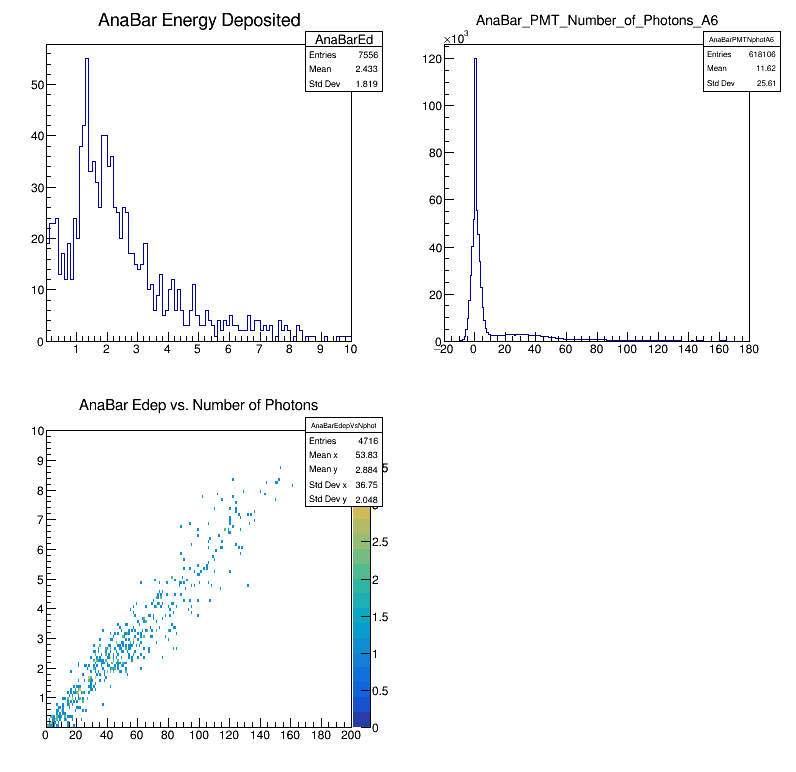

In [71]:
c8.Draw()

In [72]:
c9 = root.TCanvas("c9", "c9", 800,800)
c9.Divide(4,4, 0.01, 0.01, 0)

c9Single = root.TCanvas("c9Single", "c9Single", 800, 800)

print("Fittingi A1 ...\n")
fr = [float, float]
fp, fpe = [float, float, float, float], [float, float, float, float]
pllo = [0.05, 0.5, 1.0, 0.04]
plhi = [10.0, 50.0, 10000.0, 5.0]
sv = [1.8, 5.0, 1400.0, 3.0]
chisqr = float
ndf = int
SNRPeak, SNRFWHM = float, float


for i in range(NUMPADDLE):
    if(i == NUMPADDLE - 1):
        c9Single.cd()
    else:
        c9.cd(i+1)

    hAnaBarPMTNphot[i].Draw()
    fr[0] = 0.7*hAnaBarPMTNphot[i].GetMean()
    fr[1] = 25.0*hAnaBarPMTNphot[i].GetMean()
    #fitsnr = root.TF1(hAnaBarPMTNphot[i],fr,sv,pllo,plhi,fp,fpe,chisqr,ndf)
    #langaupro(fp,SNRPeak,SNRFWHM)

Fittingi A1 ...



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c9
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c9Single


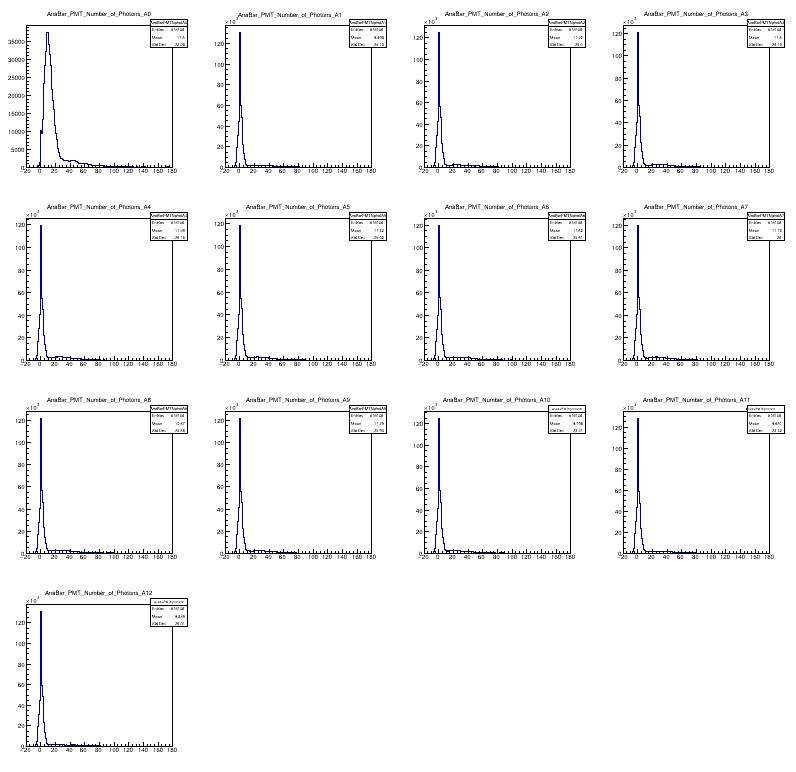

In [73]:
c9.Draw()

In [74]:
c10 = root.TCanvas("c10", "c10", 800,800)
c10.Divide((1,2, 0.01, 0.01, 0))

c10.cd(1)
hFingerPMTKE.Draw()
c10.cd(2)
hAnaBarPMTKEA1.Draw()

TypeError: void TPad::Divide(int nx = 1, int ny = 1, float xmargin = 0.01, float ymargin = 0.01, int color = 0) =>
    TypeError: could not convert argument 1 (int/long conversion expects an integer object)

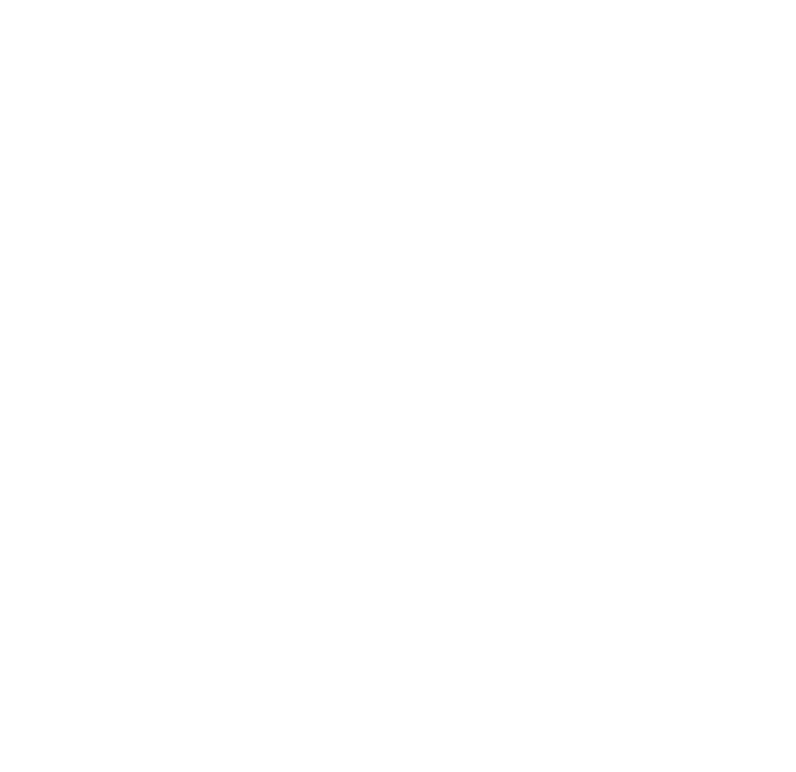

In [75]:
c10.Draw()

In [76]:
c11 = root.TCanvas("c11", "c11", 800,800)
c11.Divide(1,1, 0.01, 0.01, 0)

c11.cd(1)
hAnaBarMult.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c11


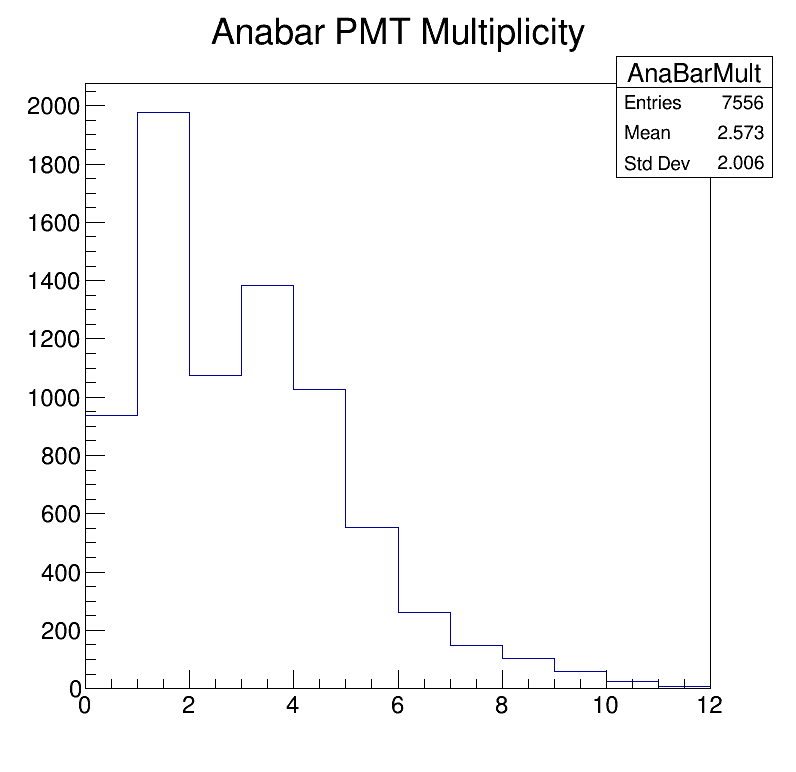

In [77]:
c11.Draw()

In [78]:
c12 = root.TCanvas("c12", "c12", 800,800)
c12.Divide(2,2, 0.01, 0.01, 0)

c12.cd(1)
hPrimPx.Draw()
c12.cd(2)
hPrimPy.Draw()
c12.cd(3)
hPrimPz.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c12


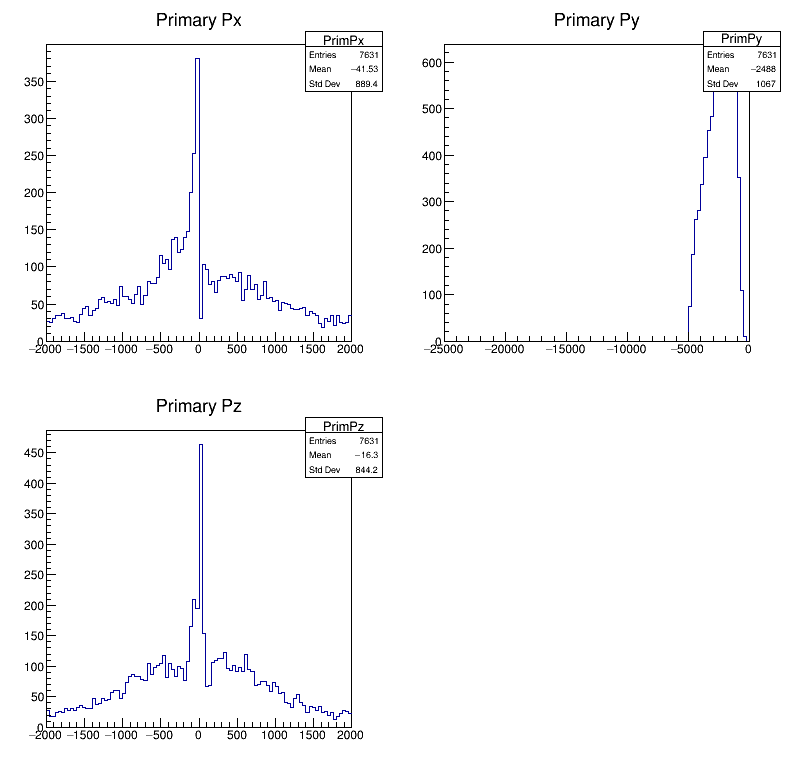

In [79]:
c12.Draw()